<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Dataset processing
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Leaf Clinical Trials
  </div>


  <div style=" float:left; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE -  Hybrid Intelligence
  </div> 


<a id="TOC"></a>

##### Table Of Content

1. [LCT Texts](#texts) <br>
2. [LCT Entities](#ents) <br>
3. [LCT Graph](#graph) <br>
4. [LCT Entities mapped to CHIA format](#ents_chia) <br>


#### Useful links

- The Leaf Clinical Trials Corpus: a new resource for query generation from clinical trial eligibility criteria, [paper](https://www.nature.com/articles/s41597-022-01521-0), [dataset](https://figshare.com/articles/dataset/lct_corpus_tar_gz/17209610), [github](https://github.com/uw-bionlp/clinical-trials-gov-data)

In [239]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
import os
import sys
import re
import copy
import json
import tarfile

# data
import numpy as np
import pandas as pd
import networkx as nx

# text
from spacy.lang.en import English

# viz
import pyvis.network as nt

#### Custom variables

In [241]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'lct')
path_to_src  = os.path.join(path_to_repo, 'src')
path_to_src

'C:\\Users\\jb\\Desktop\\NLP\\perso - Transformers for NLP\\src'

In [242]:
base_dataset_name  = 'lct_corpus.tar.gz'
final_dataset_name = 'lct-ner'

#### Custom imports

In [243]:
sys.path.insert(0, path_to_src)

In [244]:
from nlptools.dataset.chia.preprocessing import get_ner_entities, convert_to_bio

<a id="texts"></a>

# 1. LCT Texts

[Table of content](#TOC)

In [245]:
def load_texts_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        text_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.txt')]
        texts = []
        for name, member in text_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                text = f.read().decode('utf-8').replace('⁄', '/')
                texts.append([_id, text])
            
    df_texts = pd.DataFrame(texts, columns = ['Id', 'Text'])
    return df_texts

In [246]:
folder = os.path.join(path_to_data, final_dataset_name)
if not os.path.isdir(folder):
    os.makedirs(folder)

In [247]:
df_texts = load_texts_from_targzfile(os.path.join(path_to_data, base_dataset_name))

In [248]:
df_texts.head()

,Id,Text
0,NCT03862404,"Inclusion Criteria:\n - Male and Female, bet..."
1,NCT03861858,Inclusion Criteria:\n - Age 13-17 years or 1...
2,NCT03869021,Inclusion Criteria:\n 1. Patients free from a...
3,NCT03864263,Inclusion Criteria:\n - The father or (and) ...
4,NCT03862612,Inclusion Criteria:\n - Male and Female part...


In [249]:
df_texts.shape

(1006, 2)

In [250]:
df_texts.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_texts.tsv'), sep = "\t", index = False)

In [251]:
# sanity check : no overlap with chia
df_chia = pd.read_csv(os.path.join(path_to_repo, 'datasets', 'chia', 'chia-ner', 'chia_texts.tsv'), sep = "\t")

chia_ids = set([t.split('_')[0] for t in df_chia.Id.tolist()])
lct_ids  = set(df_texts.Id.tolist())
print(
    len(chia_ids & lct_ids),
    len(lct_ids - chia_ids),
    len(chia_ids - lct_ids),
)

0 1006 1000


<a id="ents"></a>

# 2. LCT Entities

[Table of content](#TOC)

## 2.1 Load entities as single spans

[Table of content](#TOC)


#### Remark

Entities are multi-spanned, and are here replaced by their full spans

In [252]:
def load_entities_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        ann_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.ann')]
        ent_list = []
        for name, member in ann_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                lines = [l.decode('utf-8').replace('⁄', '/').strip() for l in f.readlines()]
                ents = [[_id] + load_entity_line(l) for l in lines if l.startswith('T')]
                ent_list += ents
            
    df_ents = pd.DataFrame(ent_list, columns = [
        'Id', 'Entity_id', 'Mention', 'Category', 'Start_char', 'End_char', 'Char_spans',
    ])
    return df_ents

In [317]:
df_ents = load_entities_from_targzfile(os.path.join(path_to_data, base_dataset_name))
df_ents.shape

(56093, 7)

In [318]:
# A sanity check:
check = []
for _id, text in df_texts.values.tolist():
    df_tmp = df_ents[df_ents.Id == _id]
    check_tmp = df_tmp.apply(
        func = lambda r: [_id, r.Mention, text[r.Start_char: r.End_char]],
        axis = 1,
    ).tolist()
    check += check_tmp
    
df_check = pd.DataFrame(check, columns = ['Id', 'Mention', 'Span'])

# Mention and Span are indeed the same for all entities:
df_check[df_check.Mention != df_check.Span]

,Id,Mention,Span


In [319]:
df_ents.head()

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans
0,NCT03865342,T1,diabetes,Condition,387,395,"(387, 395)"
1,NCT03865342,T2,diabetes,Condition-Name,387,395,"(387, 395)"
2,NCT03865342,T3,English,Language,25,32,"(25, 32)"
3,NCT03865342,T4,given birth,Condition,661,672,"(661, 672)"
4,NCT03865342,T5,given birth,Condition-Name,661,672,"(661, 672)"


## 2.2 Get flattened non-overlapping entities

[Table of content](#TOC)

See the list of categories at [Leaf CT Wiki](https://github.com/uw-bionlp/clinical-trials-gov-annotation/wiki)

In [258]:
categories = [
    # Demographics & Family
    # ---------------------
    'Age',
    # 'Ethnicity',
    # 'Family-Member',
    # 'Language',
    'Life-Stage-And-Gender',
    
    
    # Biomedical
    # ----------
    'Allergy',
    # 'Birth',
    'Condition',
    # 'Death',
    'Drug',
     # 'Encounter',
    'Immunization',
    'Observation',
    'Organism',
    'Procedure',
    # 'Provider',
    
    
    # Boolean, Negations, & Conjunctives
    # ----------------------------------
    'And',
    'Assertion',
    'Exception',
    'Negation',
    'Or',
    
    
    # Temporal & Numerical
    # --------------------
    'Equality-Comparison',
    'Temporal-Connection',
    # 'Other',
    'Acuteness',
    'Contraindication',
    # 'Coreference',
    'Criteria-Count',
    'Indication',
    # 'Location',
    'Modifier',
    # 'Other',
    'Polarity',
    # 'Risk',
    'Severity',
    'Stability',
    # 'Study',
]

In [259]:
df_flat = get_ner_entities(df_texts, df_ents, categories)
df_flat.shape

(23017, 6)

In [260]:
df_flat.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT03860012,inflammatory bowel disease,25,51,"(T13,)",Condition
1,NCT03860012,methotrexate,60,72,"(T15,)",Drug
2,NCT03860012,normal,100,106,"(T19,)",Polarity
3,NCT03860012,folate levels,107,120,"(T17,)",Observation
4,NCT03860012,treatment,144,153,"(T26,)",Procedure


In [359]:
df_flat.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_ents_dummy.tsv'), sep = "\t", index = False)

## 2.3 Convert entities to BIO format

[Table of content](#TOC)


In [262]:
df_spans = convert_to_bio(df_texts, df_flat)
df_spans.shape

(53897, 4)

In [263]:
df_spans.head()

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion Criteria:,O
1,NCT03862404,NCT03862404_1,-,O
2,NCT03862404,NCT03862404_1,Male,Life-Stage-And-Gender
3,NCT03862404,NCT03862404_1,and,O
4,NCT03862404,NCT03862404_1,Female,Life-Stage-And-Gender


In [360]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_spans_dummy.tsv'), sep = "\t", index = False)

In [265]:
tokenizer = English()

df_bio = convert_to_bio(df_texts, df_flat, tokenizer = lambda s: [t.text for t in tokenizer(s)])
df_bio.shape

(147901, 4)

In [266]:
df_bio.head(10)

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion,O
1,NCT03862404,NCT03862404_0,Criteria,O
2,NCT03862404,NCT03862404_0,:,O
3,NCT03862404,NCT03862404_1,,O
4,NCT03862404,NCT03862404_1,-,O
5,NCT03862404,NCT03862404_1,,O
6,NCT03862404,NCT03862404_1,Male,B-Life-Stage-And-Gender
7,NCT03862404,NCT03862404_1,,O
8,NCT03862404,NCT03862404_1,and,O
9,NCT03862404,NCT03862404_1,Female,B-Life-Stage-And-Gender


In [361]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_bio_dummy.tsv'), sep = "\t", index = False)

<a id="graph"></a>

# 3. LCT Graph

[Table of content](#TOC)

## 3.1 Load LCT dataset into graph

[Table of content](#TOC)

#### Remark

Entities are multi-spanned, and are here replaced by their full spans

In [268]:
def load_entity_line(l):
    ent = l.split('\t')
    ent_id = ent[0]
    ent_txt = ent[2]
    ent_cat = ent[1].replace(';', ' ').split(' ')[0]
    spans = tuple([int(v) for v in ent[1].replace(';', ' ').split(' ')[1:]])
    return [ent_id, ent_txt, ent_cat, min(spans), max(spans), spans]



def load_graph_from_targzfile(targz_file):
    with tarfile.open(targz_file, "r:gz") as archive:
        ann_files = [(f.name, f) for f in archive.getmembers() if f.name.endswith('.ann')]
        all_nodes = []
        all_edges = []
        for name, member in ann_files:
            f = archive.extractfile(member)
            if f is not None:
                _id = name.split('/')[-1][:-4]
                lines = [l.decode('utf-8').replace('⁄', '/').strip() for l in f.readlines()]

                # load node attributes as attr-name / target-id / attr-value
                a_attrs = [l.replace('\t', ' ').split(' ')[-3:] for l in lines if l.startswith('A')]

                # load nodes corresponding to textual entities
                t_nodes = [load_entity_line(l) for l in lines if l.startswith('T')]
                t_nodes = [{
                    'Node_id': '-'.join((_id, n[0])),
                    'Study_id': _id,
                    'Entity_id': n[0],
                    'Mention': n[1],
                    'Category': n[2],
                    'Start_char': n[3],
                    'End_char': n[4],
                    'Char_spans': n[5],
                    'Normalization': [(a[0], a[-1]) for a in a_attrs if a[-2] == n[0]], # (a_attrs['-'.join((_id, n[0]))] if '-'.join((_id, n[0])) in a_attrs else ''),
                    } 
                    for n in t_nodes
                ]

                # load nodes corresponding to metadata 
                e_nodes = [l.replace('\t', ' ').split(' ') for l in lines if l.startswith('E')]
                e_nodes = [{
                    'Node_id': '-'.join((_id, n[0])),
                    'Study_id': _id,
                    'Entity_id': n[0],
                    'Mention': '',
                    'Category': '',
                    'Start_char': '',
                    'End_char': '',
                    'Char_spans': tuple(),
                    'Normalization': [(a[0], a[-1]) for a in a_attrs if a[-2] == n[0]], # (a_attrs['-'.join((_id, n[0]))] if '-'.join((_id, n[0])) in a_attrs else ''),
                    } 
                    for n in e_nodes
                ]
                nodes = t_nodes + e_nodes
                nodes = [(n['Node_id'], n) for n in nodes]
                
                # load edges carrying relationships
                e_edges = [l.replace('\t', ' ').split(' ') for l in lines if l.startswith('E')]
                e_edges = [{
                    's': '-'.join((_id, es[0])),
                    't': '-'.join((_id, e.split(':')[1])),
                    'Edge_id': es[0],
                    'label': e.split(':')[0],
                    } 
                    for es in e_edges for e in es[1:] if (':' in e)
                ]
                
                # load edges carrying meta-relations
                r_edges = [l.replace('\t', ' ').split(' ')[:4] for l in lines if l.startswith('R')]
                r_edges = [{
                    's': '-'.join((_id, s.split(':')[1])),
                    't': '-'.join((_id, t.split(':')[1])),
                    'Edge_id': e_id,
                    'label': label,
                    } 
                    for e_id, label, s, t in r_edges
                ]
                edges = e_edges + r_edges
                edges = [(e['s'], e['t'], e) for e in edges]
                
                all_nodes += nodes
                all_edges += edges
            
    nx_graph = nx.MultiDiGraph()
    nx_graph.add_nodes_from(all_nodes)
    nx_graph.add_edges_from(all_edges)
    return nx_graph

In [269]:
nx_graph = load_graph_from_targzfile(os.path.join(path_to_data, base_dataset_name))

## 3.2 Visualize graph

[Table of content](#TOC)


In [270]:
def filter_by_study(nx_graph, study):
    nodes = [n for n in nx_graph.nodes() if nx_graph.nodes[n]['Study_id'] == study]
    return nx_graph.subgraph(nodes)


def convert_nx_to_nt_graph(nx_graph, node_colors = {}, edge_weights = {}, height = 1200, width = 1980, notebook = False):
    nodes = list(nx_graph.nodes(data = True))
    edges = [(s, t, 1 + (edge_weights[e['label']] if e['label'] in edge_weights else 0)) for s, t, e in nx_graph.edges(data = True)]
    color = [(node_colors[k] if k in node_colors else '#edc939') for k, n in nodes]
    
    nt_graph = nt.Network(directed = True, height = height, width = width, notebook = notebook)
    nt_graph.add_nodes(
        nodes = [k for k, n in nodes],
        size  = [10]*len(nodes),
        label = [n['Mention'] for k, n in nodes],
        title = [n['Category'] for k, n in nodes],
        color = color,
    )
    nt_graph.add_edges(edges)
    return nt_graph

In [271]:
study = 'NCT03931941'
study = 'NCT03860038'

In [272]:
print(df_texts[df_texts.Id == study].Text.tolist()[0])

Inclusion criteria:
  1. Age ≥ 18, male or female;
  2. Subject must have had documented MM;
  3. At screening phase, subject must have measurable disease;
  4. Subject is in a state of progressive disease (PD);
  5. Subject must have life expectancy of no less than 6 months;
  6. Subject must have an ECOG (Eastern Cooperative Oncology Group) performance status score of 0~2;
Exclusion criteria:
  1. Subject has received anti-CD38 monoclonal antibody treatment previously;
  2. Subject has received CAR-T cell therapy previously;
  3. Subject has previously received allogenic stem cell transplant, or subject has received autologous stem cell transplant within 3 months before administration of the study agent;
  4. Primary refractory multiple myeloma (subject failed to generate any minimal response or any degree of response to any therapy);
  5. Subject has received anti-myeloma treatment (radiotherapy is excluded) within 4 weeks or 5 PK half-lives of the treatment, whichever longer, befor

In [273]:
nx_subgraph = filter_by_study(nx_graph, study = study)
nt_subgraph = convert_nx_to_nt_graph(
    nx_subgraph, 
    node_colors = {}, 
    edge_weights = {'Temporality': 5, },
    height = 600, 
    width = 900, 
    notebook = True,
)
nt_subgraph.save_graph(os.path.join('lct', 'misc', 'lct.html'))

nt_subgraph.show(os.path.join('lct', 'misc', 'lct.html'))

In [274]:
[e for s, t, e in nx_subgraph.edges(data = True) if e['s'] == 'NCT03860038-E21']

[{'s': 'NCT03860038-E21',
  't': 'NCT03860038-T36',
  'Edge_id': 'E21',
  'label': 'Eq-Comparison'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T21',
  'Edge_id': 'E21',
  'label': 'Operator'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T24',
  'Edge_id': 'E21',
  'label': 'Temporal-Unit'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-T31',
  'Edge_id': 'E21',
  'label': 'Value'},
 {'s': 'NCT03860038-E21',
  't': 'NCT03860038-E27',
  'Edge_id': 'R6',
  'label': 'Before'}]

<a id="ents_chia"></a>

# 4. LCT Entities mapped to CHIA format

[Table of content](#TOC)

## 4.1 Create new category column

[Table of content](#TOC)


In [338]:
def get_parent_type(nx_graph, node_id):
    '''
    This function rely on the fact that each node has a single parent,
    and its normalization is unique, if it exists.
    '''
    p_type = ''
    parent = list(nx_graph.predecessors(node_id))
    if parent:
        p_type = nx_graph.nodes[parent[0]]['Normalization']
        p_type = (p_type[0][-1] if p_type else '')
    return p_type

In [321]:
df_ents.loc[:, 'Category_chia'] = df_ents.Category

In [322]:
df_ents.loc[:, 'Type'] = df_ents.apply(
    func = lambda r: get_parent_type(nx_graph, '-'.join([r.Id, r.Entity_id])),
    axis = 1,
).tolist()

In [323]:
df_ents.shape

(56093, 9)

In [324]:
df_ents

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
0,NCT03865342,T1,diabetes,Condition,387,395,"(387, 395)",Condition,
1,NCT03865342,T2,diabetes,Condition-Name,387,395,"(387, 395)",Condition-Name,
2,NCT03865342,T3,English,Language,25,32,"(25, 32)",Language,
3,NCT03865342,T4,given birth,Condition,661,672,"(661, 672)",Condition,
4,NCT03865342,T5,given birth,Condition-Name,661,672,"(661, 672)",Condition-Name,
...,...,...,...,...,...,...,...,...,...
56088,NCT03931772,T98,motivation,Assertion,136,146,"(136, 146)",Assertion,intention
56089,NCT03931772,T100,or older,Eq-Operator,34,42,"(34, 42)",Eq-Operator,
56090,NCT03931772,T65,quit smoking,Observation,167,179,"(167, 179)",Observation,
56091,NCT03931772,T97,10-point Likert-type scale,Modifier,185,211,"(185, 211)",Modifier,


<AxesSubplot: >

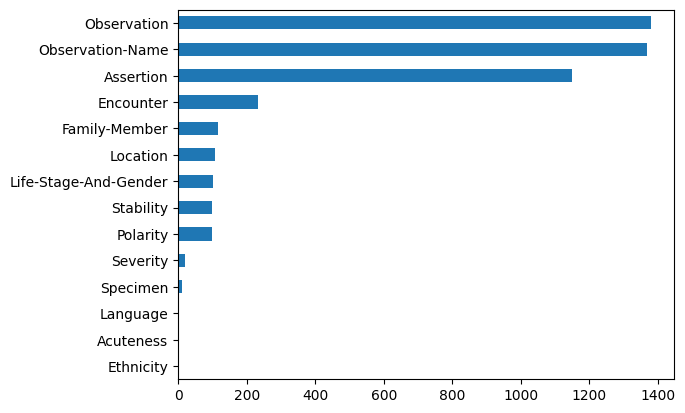

In [325]:
df_ents[(df_ents.Type != '')].Category.value_counts().sort_values().plot(kind = 'barh')

## 4.2 Fill _Person_ category

[Table of content](#TOC)


In [326]:
# Person : we ignored Ethnicity, Family-member, Language
person_idx = df_ents.Category.isin(['Life-Stage-And-Gender', 'Age']) 

In [327]:
sum(person_idx)

1436

In [328]:
df_ents.loc[person_idx, 'Category_chia'] = 'Person'

## 4.3 Fill _Qualifier_ category

[Table of content](#TOC)


In [330]:
# get almost all modifiers
# exclude Values found and irrelevant
qualifier_idx = (df_ents.Category.isin([
    'Modifier', 
    'Severity', 
    'Stability', 
    'Acuteness', 
    'Polarity',
])) & (~df_ents.Type.isin([
    'lab',            # Value
    'clinical-score', # Value
    'measurement',    # Value
    'survey-or-questionnaire', # Value
    'hypothetical',   # irrelevant
    'possible',       # irrelevant
    'intention',      # irrelevant
]))

In [331]:
sum(qualifier_idx)

4882

In [332]:
df_ents.loc[qualifier_idx, 'Category_chia'] = 'Qualifier'

## 4.4 Fill _Measurement_ category

[Table of content](#TOC)


Observations are organized into 6 types, plus an additional unspecified type, which we map differently to either _Measurement_ or _Observation_ OMOP-compatible category:

| Type | Target category |
|-----|-----|
| measurement | Measurement | 
| lab | Measurement | 
| vital | Measurement | 
| clinical-score | Measurement | 
| social-habit | Observation |
| survey-or-questionnaire | Observation |
|  | Observation |


See the Leaf Clinical Trial Corpus wiki on [Observation](https://github.com/uw-bionlp/clinical-trials-gov-annotation/wiki/observation) and its decomposition into types.

<AxesSubplot: >

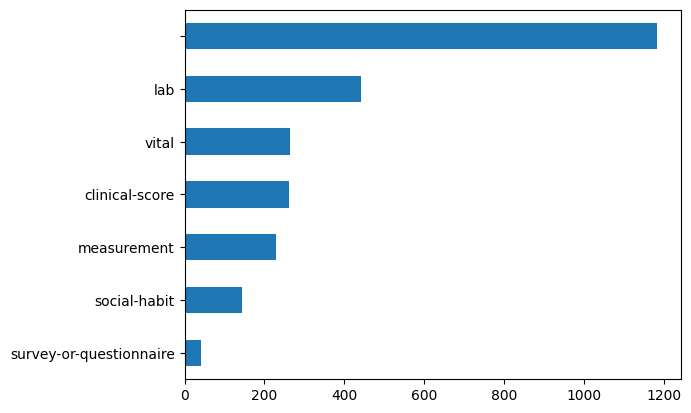

In [333]:
df_ents[(df_ents.Category == 'Observation')].Type.value_counts().sort_values().plot(kind = 'barh')

In [334]:
measurement_idx = (
    (df_ents.Category == 'Observation')
) & df_ents.Type.isin([
    'measurement',
    'lab',
    'vital',
    'clinical-score',
])

In [335]:
sum(measurement_idx)

1195

In [336]:
df_ents.loc[measurement_idx, 'Category_chia'] = 'Measurement'

## 4.5 Fill _Value & Temporal_ categories

[Table of content](#TOC)

In [341]:
def get_ancestor(nx_graph, node_id, level = 1):
    '''
    This function rely on the fact that each node has a single parent,
    and its normalization is unique, if it exists.
    '''
    parents = list(nx_graph.predecessors(node_id))
    if len(parents) >= level:
        parent = nx_graph.nodes[parents[level-1]]
        p_cat  = parent['Category']
        p_type = (parent['Normalization'][0][-1] if parent['Normalization'] else '')
        return (p_cat, p_type)
    return ('', '')

In [350]:
def get_ancestor_path(nx_graph, node, return_ancestor_level = 2):
    ancestors = nx.ancestors(nx_graph, node)
    if ancestors:
        paths = [nx.shortest_path(nx_graph, source = a, target = node) for a in ancestors]
        path = tuple(sorted(paths, key = len)[-1])
        root = path[-return_ancestor_level:][0]
        path = [
            nx_graph.get_edge_data(m, n)[0]['label']
            for m, n in zip(path[:-1], path[1:])
        ]
        path = [root, path]
    else:
        path = [node, tuple([])]
    return path



def get_descendant_paths(nx_graph, node, from_ancestor_level = 1):
    if from_ancestor_level == 0:
        root = node
    else:
        ancestors = nx.ancestors(nx_graph, node)
        if ancestors:
            paths = [nx.shortest_path(nx_graph, source = a, target = node) for a in ancestors]
            path = tuple(sorted(paths, key = len)[-1])
            root = path[-from_ancestor_level:][0]
        else:
            root = node
    return list(set([nx_graph.nodes[n]['Category'] for n in nx.descendants(nx_graph, root)]))



def get_children_edges(nx_graph, node):
    return [e['label'] for s, t, e in nx_graph.out_edges(node, data = True)]
    


def get_overlaping_entities(row, df, output_column = 'index'):
    # get entities on same Id
    df = df[df.Id == row.Id]
    df = df[df.Entity_id != row.Entity_id]
    
    lengths = df.End_char - df.Start_char
    length = row.End_char - row.Start_char
    
    idx_short = []
    idx_equal = []
    idx_large = []

    # get shorter overlaping entities
    df_short = df[lengths <= length]
    if not df_short.empty:
        short = df_short.apply(
            func = lambda r: len(set(range(r.Start_char, r.End_char)) & set(range(row.Start_char, row.End_char)))>0, 
            axis = 1,
        )
        idx_short = df_short[short][output_column].tolist()
    
    # get identical overlaping entities
    df_equal = df[lengths == length]
    if not df_equal.empty:
        equal = df_equal.apply(
            func = lambda r: (r.Start_char == row.Start_char) & (r.End_char == row.End_char), 
            axis = 1,
        )
        idx_equal = df_equal[equal][output_column].tolist()

    # get larger overlaping entities
    df_large = df[lengths > length]
    if not df_large.empty:
        large = df_large.apply(
            func = lambda r: len(set(range(r.Start_char, r.End_char)) & set(range(row.Start_char, row.End_char)))>0, 
            axis = 1,
        )
        idx_large = df_large[large][output_column].tolist()
    return (idx_short, idx_equal, idx_large)

In [351]:
df_comps = df_ents[df_ents.Category == 'Eq-Comparison'].copy()
df_comps

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type
26,NCT03865342,T29,>5 lbs,Eq-Comparison,292,298,"(292, 298)",Eq-Comparison,
27,NCT03865342,T30,within the past 3 months,Eq-Comparison,673,697,"(673, 697)",Eq-Comparison,
29,NCT03865342,T32,18 years of age and older,Eq-Comparison,47,72,"(47, 72)",Eq-Comparison,
35,NCT03865342,T41,5.7 - 6.4,Eq-Comparison,137,146,"(137, 146)",Eq-Comparison,
36,NCT03865342,T42,within the 3 months,Eq-Comparison,147,166,"(147, 166)",Eq-Comparison,
...,...,...,...,...,...,...,...,...,...
56058,NCT03931772,T29,≥ 5 out of 10,Eq-Comparison,150,163,"(150, 163)",Eq-Comparison,
56062,NCT03931772,T73,current,Eq-Comparison,671,678,"(671, 678)",Eq-Comparison,
56066,NCT03931772,T77,Currently taking,Eq-Comparison,912,928,"(912, 928)",Eq-Comparison,
56079,NCT03931772,T87,daily,Eq-Comparison,302,307,"(302, 307)",Eq-Comparison,


In [352]:
root_ancestor = df_comps.apply(
    func = lambda r: get_ancestor_path(nx_graph, '-'.join([r.Id, r.Entity_id])),
    axis = 1,
).tolist()

df_comps['Root'] = [r for r, a in root_ancestor]
df_comps['Ancestors'] = [a for r, a in root_ancestor]
df_comps['Root_edges'] = df_comps.Root.apply(lambda r: get_children_edges(nx_graph, r))
df_comps['Overlaping'] = df_comps.apply(
    func = lambda r: get_overlaping_entities(r, df_ents, output_column = 'Category'),
    axis = 1,
)

In [353]:
df_comps.head(2)

,Id,Entity_id,Mention,Category,Start_char,End_char,Char_spans,Category_chia,Type,Root,Ancestors,Root_edges,Overlaping
26,NCT03865342,T29,>5 lbs,Eq-Comparison,292,298,"(292, 298)",Eq-Comparison,,NCT03865342-E6,"[Numeric-Filter, Eq-Comparison]","[Eq-Comparison, Operator, Unit, Value]","([Eq-Operator, Eq-Unit, Eq-Value], [], [])"
27,NCT03865342,T30,within the past 3 months,Eq-Comparison,673,697,"(673, 697)",Eq-Comparison,,NCT03865342-E7,"[Temporality, Eq-Comparison]","[Eq-Comparison, Operator, Temporal-Unit, Value...","([Eq-Operator, Eq-Temporal-Unit, Eq-Value, Eq-..."


In [354]:
other_filter = df_comps.Overlaping.apply(lambda os: len(set(os[1]) & set([
    'Eq-Temporal-Recency', 'Eq-Temporal-Unit', 'Severity', 'Eq-Operator',
])) > 0)

print(sum(other_filter))


temporal_cats = ['Temporality', 'Temporality2', 'Temporality3', 'During', 'Duration', 'Duration2'] # Before, After

temporal_filter = ~other_filter & (
    df_comps.Overlaping.apply(lambda os: (os[1] == ['Eq-Temporal-Period'])) |
    df_comps.Ancestors.apply(lambda a: (len(a)>1 and a[-2] in temporal_cats)) 
)

print(sum(temporal_filter))

value_cats = ['Numeric-Filter', 'Stage', 'Dose', 'Dose2']

value_filter = ~(other_filter | temporal_filter) & (
    df_comps.Ancestors.apply(lambda a: (len(a)>1 and a[-2] in value_cats))
)

print(sum(value_filter))


temporal_filter_2 = ~(other_filter | temporal_filter | value_filter) & (
    df_comps.Overlaping.apply(lambda os: ('Eq-Temporal-Unit' in os[0]))
)

print(sum(temporal_filter_2))


value_filter_2 = ~(other_filter | temporal_filter | value_filter | temporal_filter_2) & (
    df_comps.Overlaping.apply(lambda os: ('Eq-Value' in os[0]))
)

print(sum(value_filter_2))

other_filter_2 = ~(other_filter | temporal_filter | value_filter | temporal_filter_2 | value_filter_2)

print(sum(other_filter_2))

179
2628
1989
140
324
37


In [355]:
temporal_idx = df_comps[temporal_filter | temporal_filter_2].index.tolist()
len(temporal_idx)

2768

In [356]:
value_idx = df_comps[value_filter | value_filter_2].index.tolist()
len(value_idx)

2313

In [357]:
# sanity check: these sets of indices are disjoint
len(set(value_idx) & set(temporal_idx))

0

In [358]:
df_ents.loc[temporal_idx, 'Category_chia'] = 'Temporal'
df_ents.loc[value_idx, 'Category_chia'] = 'Value'

## 4.6 Get flattened non-overlapping entities

[Table of content](#TOC)


In [363]:
categories_chia = [
    # domain
    'Condition',
    'Procedure',
    'Drug',
    'Person',      # created from 'Life-Stage-And-Gender' and 'Age'
    'Measurement', # created from subset of 'Observation'
    'Observation', # created from subset of 'Observation'
    # 'Device' missing
    
    # field
    'Value',     # replaces part of 'Eq-Comparison'
    'Temporal',  # replaces part of 'Eq-Comparison'
    'Qualifier', # replaces 'Modifier', 'Severity', 'Assertion', 'Stability', 'Acuteness', 'Polarity'
]

In [383]:
df_ents = df_ents[df_ents.Category_chia.isin(categories_chia)].reset_index(drop = True).copy()
df_ents.loc[:, 'Category'] = df_ents.Category_chia
df_ents.shape

(25449, 9)

In [373]:
df_flat = get_ner_entities(df_texts, df_ents, categories) 
df_flat.shape

(25321, 6)

In [379]:
df_flat.head()

,Id,Mention,Start_char,End_char,Entity_id,Category
0,NCT03860012,inflammatory bowel disease,25,51,"(T13,)",Condition
1,NCT03860012,on,57,59,"(T31,)",Temporal
2,NCT03860012,methotrexate,60,72,"(T15,)",Drug
3,NCT03860012,folate levels,107,120,"(T17,)",Measurement
4,NCT03860012,treatment,144,153,"(T26,)",Procedure


<AxesSubplot: >

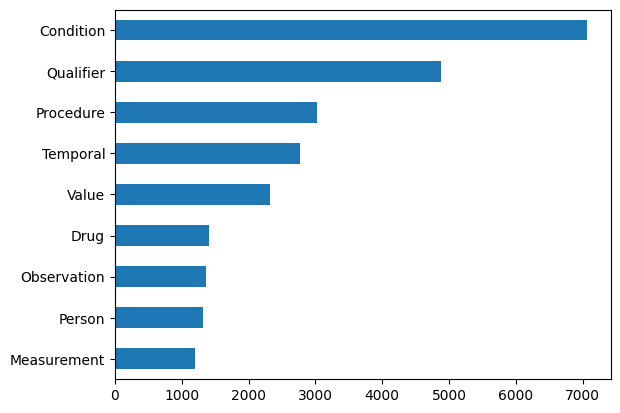

In [381]:
df_flat.Category.value_counts().sort_values().plot(kind = 'barh')

In [374]:
df_flat.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_ents.tsv'), sep = "\t", index = False)

## 4.7 Convert entities to BIO format

[Table of content](#TOC)


In [375]:
df_spans = convert_to_bio(df_texts, df_flat)
df_spans.shape

(57634, 4)

In [376]:
df_spans.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_spans.tsv'), sep = "\t", index = False)

In [377]:
tokenizer = English()

df_bio = convert_to_bio(df_texts, df_flat, tokenizer = lambda s: [t.text for t in tokenizer(s)])
df_bio.shape

(148708, 4)

In [380]:
df_bio.head()

,Id,Sequence_id,Mention,Category
0,NCT03862404,NCT03862404_0,Inclusion,O
1,NCT03862404,NCT03862404_0,Criteria,O
2,NCT03862404,NCT03862404_0,:,O
3,NCT03862404,NCT03862404_1,,O
4,NCT03862404,NCT03862404_1,-,O


In [378]:
df_bio.to_csv(os.path.join(path_to_data, final_dataset_name, 'lct_bio.tsv'), sep = "\t", index = False)

[Table of content](#TOC)